# Visualização Indicador Incidência 


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
taxa_deteccao = pd.read_csv('../data/indicadores/visceral/indicador_15_taxa_incidencia_municipio_infeccao.csv')
taxa_deteccao = taxa_deteccao.set_index('CO_MN_INF')

In [3]:
total_casos = pd.read_csv('../data/indicadores/visceral/indicador_14_total_casos_novos_municipio_infeccao.csv')
total_casos = total_casos.set_index('CO_MN_INF')

In [4]:
municipios = pd.read_csv('../data/processed/municipios.csv')

### Taxas de detecção para Ourilândia e Parauapebas

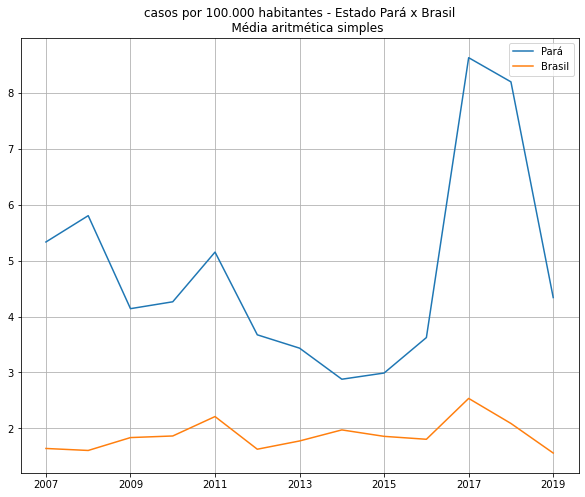

In [5]:
para = taxa_deteccao.loc[
    municipios.ibge_code[municipios.estado == 'Pará'].values, 
    :
].mean()
brasil = taxa_deteccao.loc[:,:].mean()
t = pd.concat([para, brasil],axis=1)
t.columns = ['Pará', 'Brasil']
t.plot(
    figsize=(10,8), 
    grid=True, 
    title='''casos por 100.000 habitantes - Estado Pará x Brasil
    Média aritmética simples'''
);

In [6]:
municipios.loc[municipios.estado == 'Pará','mesorregiao'].unique()

array(['Nordeste Paraense', 'Sudeste Paraense', 'Marajó',
       'Baixo Amazonas', 'Sudoeste Paraense', 'Metropolitana de Belém'],
      dtype=object)

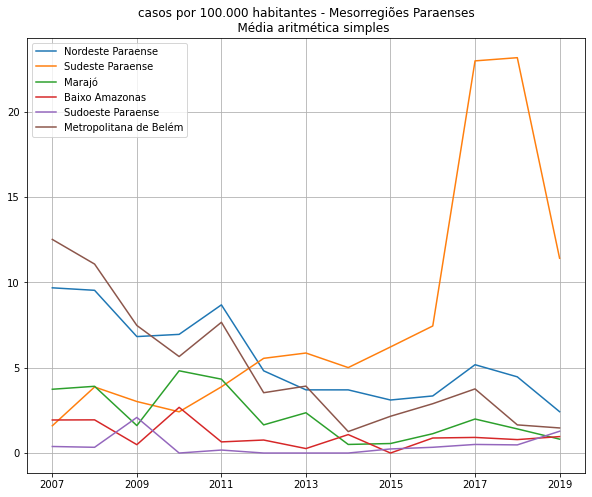

In [7]:
#mesorregioes
ne = taxa_deteccao.loc[
    municipios.ibge_code[municipios.mesorregiao == 'Nordeste Paraense'].values, 
    :
].mean()
se = taxa_deteccao.loc[
    municipios.ibge_code[municipios.mesorregiao == 'Sudeste Paraense'].values, 
    :
].mean()
marajo = taxa_deteccao.loc[
    municipios.ibge_code[municipios.mesorregiao == 'Marajó'].values, 
    :
].mean()
baixo_am = taxa_deteccao.loc[
    municipios.ibge_code[municipios.mesorregiao == 'Baixo Amazonas'].values, 
    :
].mean()
so = taxa_deteccao.loc[
    municipios.ibge_code[municipios.mesorregiao == 'Sudoeste Paraense'].values, 
    :
].mean()
metropolitana = taxa_deteccao.loc[
    municipios.ibge_code[municipios.mesorregiao == 'Metropolitana de Belém'].values, 
    :
].mean()

t = pd.concat([ne, se, marajo, baixo_am, so, metropolitana],axis=1)
t.columns = municipios.loc[municipios.estado == 'Pará','mesorregiao'].unique()
#display(t)
t.plot(
    figsize=(10,8), 
    grid=True, 
    title='''casos por 100.000 habitantes - Mesorregiões Paraenses
    Média aritmética simples'''
);

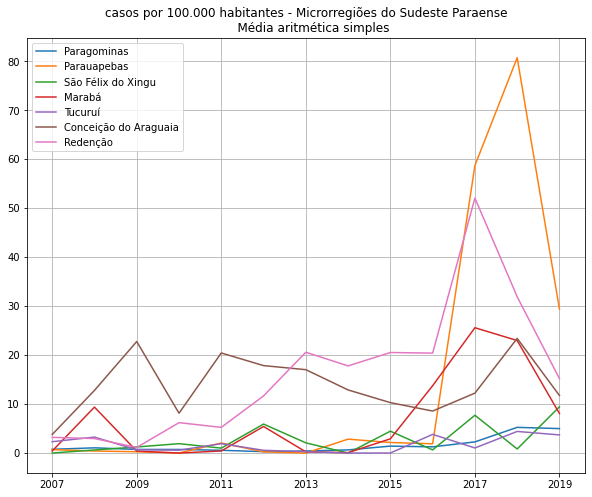

In [8]:
d = {}
for micro in municipios.microrregiao[municipios.mesorregiao == 'Sudeste Paraense']:
    d.update({micro: municipios.ibge_code[municipios.microrregiao == micro].values})

paragominas = taxa_deteccao.loc[d['Paragominas'], :].mean()
parauapebas = taxa_deteccao.loc[d['Parauapebas'], :].mean()
sao_felix = taxa_deteccao.loc[d['São Félix do Xingu'], :].mean()
maraba = taxa_deteccao.loc[d['Marabá'], :].mean()
tucurui = taxa_deteccao.loc[d['Tucuruí'], :].mean()
conceicao = taxa_deteccao.loc[d['Conceição do Araguaia'], :].mean()
redencao = taxa_deteccao.loc[d['Redenção'], :].mean()

t = pd.concat([paragominas, parauapebas, sao_felix, maraba, tucurui, conceicao, redencao], axis=1)
t.columns = d.keys()

t.plot(
    figsize=(10,8), 
    grid=True, 
    title='''casos por 100.000 habitantes - Microrregiões do Sudeste Paraense
    Média aritmética simples'''
);

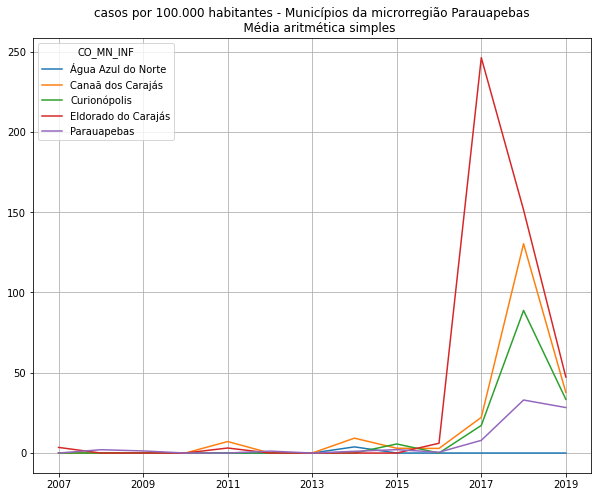

In [9]:
t = taxa_deteccao.loc[municipios.loc[municipios.microrregiao == 'Parauapebas', :].ibge_code, :]
t.index = t.index.map(
    dict(zip(
        municipios.loc[municipios.microrregiao == 'Parauapebas', :].ibge_code,
        municipios.loc[municipios.microrregiao == 'Parauapebas', :].municipio
        )))
t.T.plot(
    figsize=(10,8), 
    grid=True, 
    title='''casos por 100.000 habitantes - Municípios da microrregião Parauapebas
    Média aritmética simples'''
);

### 1) Alguns municípios vizinhos estão enfrentando uma taxa alta de casos. Como isso se relaciona com este município espacial e temporalmente? Quais municípios vizinhos estão tendo alta nas taxas?
- definir os municípios vizinhos

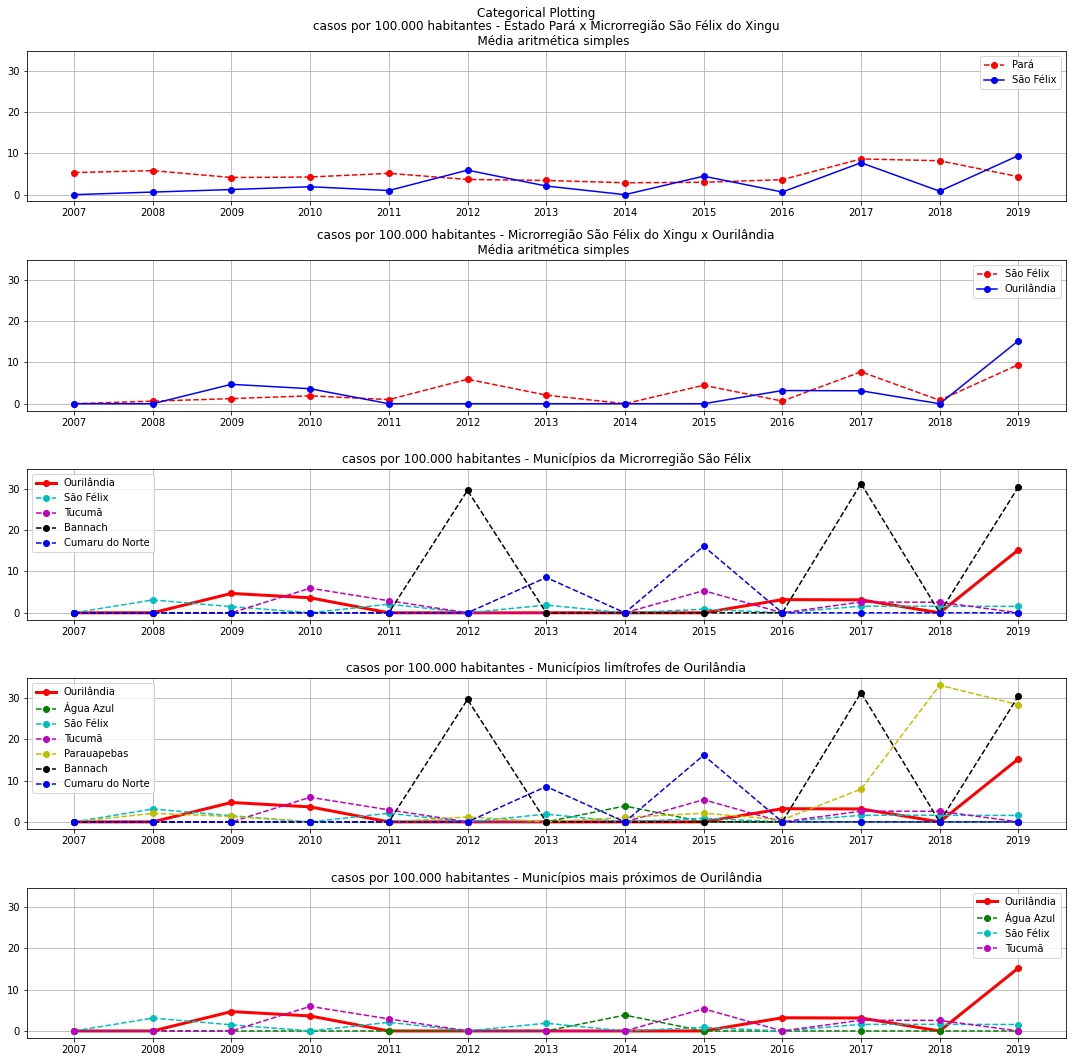

In [10]:
years = taxa_deteccao.columns.values

para = taxa_deteccao.loc[
    municipios.ibge_code[municipios.estado == 'Pará'].values, 
    :
].mean()

sf_media = taxa_deteccao.loc[
    municipios.loc[municipios.microrregiao == 'São Félix do Xingu'].ibge_code.values, :
].mean()


sf_municipios = taxa_deteccao.loc[
    municipios.loc[municipios.microrregiao == 'São Félix do Xingu'].ibge_code.values, :
]
sf_municipios.index = sf_municipios.index.map(dict(zip(
    municipios.loc[municipios.microrregiao == 'São Félix do Xingu', 'ibge_code'],
    municipios.loc[municipios.microrregiao == 'São Félix do Xingu', 'municipio']
)))

ou = taxa_deteccao.loc[150543, :]

limitrofes = ['Ourilândia do Norte', 'Água Azul do Norte', 'São Félix do Xingu', 'Tucumã', 'Parauapebas', 'Bannach', 'Cumaru do Norte']
idx = []
for it in limitrofes:
    idx.append(municipios.loc[municipios.municipio == it, :].index.values[0])
limitrofes = municipios.loc[idx, :]
limitrofes = limitrofes.set_index('ibge_code')
limitrofes

ou_vizinhos = taxa_deteccao.loc[limitrofes.index,:].copy()
ou_vizinhos.index = ou_vizinhos.index.map(dict(zip(limitrofes.index, limitrofes.municipio)))

ou_vizinhos_proximos_pairs = {150543: 'Ourilândia do Norte', 150034: 'Água Azul do Norte', 150730: 'São Félix do Xingu', 150808: 'Tucumã'}
ou_vizinhos_proximos = taxa_deteccao.loc[ou_vizinhos_proximos_pairs.keys(), :]
ou_vizinhos_proximos.index = ou_vizinhos_proximos.index.map(ou_vizinhos_proximos_pairs)

fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharey=True)
axs[0].grid(True)
axs[0].plot(years, para.values, 'ro--', label='Pará')
axs[0].plot(years, sf_media.values, 'bo-', label='São Félix')
axs[0].set_title('''casos por 100.000 habitantes - Estado Pará x Microrregião São Félix do Xingu
    Média aritmética simples''')
axs[0].legend()

axs[1].grid(True)
axs[1].plot(years, sf_media.values, 'ro--', label='São Félix')
axs[1].plot(years, ou.values, 'bo-', label='Ourilândia')
axs[1].set_title('''casos por 100.000 habitantes - Microrregião São Félix do Xingu x Ourilândia
    Média aritmética simples''')
axs[1].legend()

axs[2].grid(True)
axs[2].plot(years, sf_municipios.loc['Ourilândia do Norte', :], 'ro-', linewidth=3, label='Ourilândia')
axs[2].plot(years, sf_municipios.loc['São Félix do Xingu', :], 'co--', label='São Félix')
axs[2].plot(years, sf_municipios.loc['Tucumã', :], 'mo--', label='Tucumã')
axs[2].plot(years, sf_municipios.loc['Bannach', :], 'ko--', label='Bannach')
axs[2].plot(years, sf_municipios.loc['Cumaru do Norte', :], 'bo--', label='Cumaru do Norte')
axs[2].set_title('''casos por 100.000 habitantes - Municípios da Microrregião São Félix''')
axs[2].legend()

axs[3].grid(True)
axs[3].plot(years, ou_vizinhos.loc['Ourilândia do Norte', :], 'ro-', linewidth=3, label='Ourilândia')
axs[3].plot(years, ou_vizinhos.loc['Água Azul do Norte', :], 'go--', label='Água Azul')
axs[3].plot(years, ou_vizinhos.loc['São Félix do Xingu', :], 'co--', label='São Félix')
axs[3].plot(years, ou_vizinhos.loc['Tucumã', :], 'mo--', label='Tucumã')
axs[3].plot(years, ou_vizinhos.loc['Parauapebas', :], 'yo--', label='Parauapebas')
axs[3].plot(years, ou_vizinhos.loc['Bannach', :], 'ko--', label='Bannach')
axs[3].plot(years, ou_vizinhos.loc['Cumaru do Norte', :], 'bo--', label='Cumaru do Norte')
axs[3].set_title('''casos por 100.000 habitantes - Municípios limítrofes de Ourilândia''')
axs[3].legend()


axs[4].grid(True)
axs[4].plot(years, ou_vizinhos_proximos.loc['Ourilândia do Norte', :], 'ro-', linewidth=3, label='Ourilândia')
axs[4].plot(years, ou_vizinhos_proximos.loc['Água Azul do Norte', :], 'go--', label='Água Azul')
axs[4].plot(years, ou_vizinhos_proximos.loc['São Félix do Xingu', :], 'co--', label='São Félix')
axs[4].plot(years, ou_vizinhos_proximos.loc['Tucumã', :], 'mo--', label='Tucumã')
axs[4].set_title('''casos por 100.000 habitantes - Municípios mais próximos de Ourilândia''')
axs[4].legend()


fig.suptitle('Categorical Plotting')
fig.tight_layout()
plt.show()


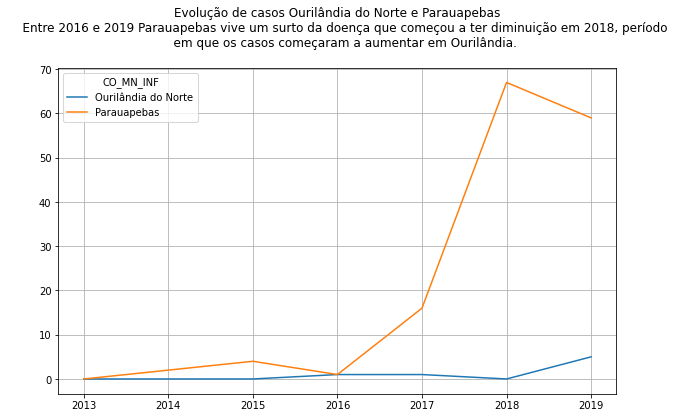

In [11]:
d = total_casos.loc[[150543, 150553], ['2013','2014','2015','2016','2017','2018','2019']].copy()
d.index = d.index.map({150543:'Ourilândia do Norte', 150553:'Parauapebas'})
d.T.plot(
    kind='line', 
    grid=True,
    figsize=(10,6),
    title='''Evolução de casos Ourilândia do Norte e Parauapebas
    Entre 2016 e 2019 Parauapebas vive um surto da doença que começou a ter diminuição em 2018, período
    em que os casos começaram a aumentar em Ourilândia.\n'''
);

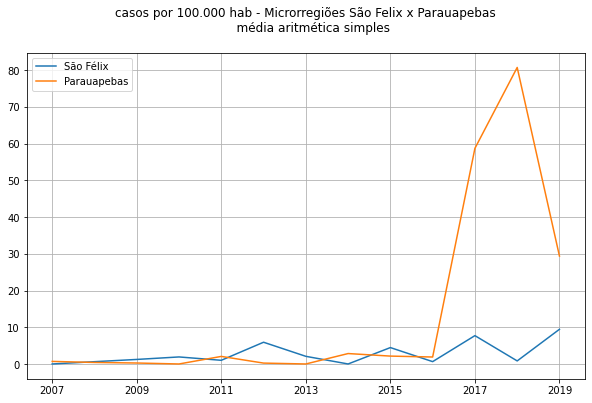

In [12]:
a = taxa_deteccao.loc[
    municipios.loc[municipios.microrregiao == 'São Félix do Xingu'].ibge_code.values, :
].mean()

b = taxa_deteccao.loc[
    municipios.loc[municipios.microrregiao == 'Parauapebas'].ibge_code.values, :
].mean()
t = pd.concat([a,b], axis=1)
t.columns = ['São Félix', 'Parauapebas']
t.plot(
    kind='line', 
    grid=True,
    figsize=(10,6),
    title='''casos por 100.000 hab - Microrregiões São Felix x Parauapebas
    média aritmética simples\n'''
);

Entre 2007 e 2016 a quantidade de casos se mantém estável abaixo de 10 por ano. Entretanto, entre 2016 e 2018, especialmente, o município de Parauapebas vive um surto intenso. Entre 2018 e 2019, quando começa a diminuir os casos, Ourilândia experimenta aumento de notificações. Mas nada perto da quantidade enorme do vizinho.

Ourilândia e Parauapebas, apesar de serem limítrofes, não são tão próximos, a rota menor é de 250km. A principal relação que existe entre os dois é uma empresa de mineração. 

- Como Ourilândia não tem um histórico de casos de LV, acho que esses casos são de pessoas que vieram de lá ou de outro município que viveu forte surto, como Marabá, Eldorado, Canaã e Curionópolis, todos próximos. Os registros dizem que foram casos autóctones, então isso descartaria essa hipótese.


### Analisando as notificações de Ourilândia

- Infelizmente nas notificações os campos que informam sobre deslocamento nos últimos 6 meses estão vazios, não tem como saber onde as pessoas estiveram. Mas são indicados como casos autóctones, ou seja, se infectaram no próprio município, segundo as notificações.

In [13]:
df = pd.read_csv('../data/interim/leivis/casos_confirmados_full_limpos.csv', low_memory=False)

In [14]:
ouri = df.loc[
    (df.CO_MN_INF == 150543) & (df.ANO == 2019), 
    :
]
ouri.index = ouri.index.map(dict(zip(ouri.index, ['Mulher A', 'Mulher B', 'Homem A', 'Homem B', 'Mulher C'])))

In [15]:
ouri.loc[
    (ouri.CO_MN_INF == 150543) & (ouri.ANO == 2019), 
    ['DT_DESLC1', 'DS_MUN_1', 'CO_UF_1', 'CO_PAIS_1', 'DS_TRANS_1', 
     'DT_DESLC2', 'DS_MUN_2', 'CO_UF_2', 'CO_PAIS_2', 'DS_TRANS_2', 
     'DT_DESLC3', 'DS_MUN_3', 'CO_UF_3', 'CO_PAIS_3', 'DS_TRANS_3']
]

,DT_DESLC1,DS_MUN_1,CO_UF_1,CO_PAIS_1,DS_TRANS_1,DT_DESLC2,DS_MUN_2,CO_UF_2,CO_PAIS_2,DS_TRANS_2,DT_DESLC3,DS_MUN_3,CO_UF_3,CO_PAIS_3,DS_TRANS_3
Mulher A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Mulher B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Homem A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Homem B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Mulher C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
ouri.loc[
    (ouri.CO_MN_INF == 150543) & (ouri.ANO == 2019), 
    'TPAUTOCTO'
]

Mulher A    1
Mulher B    1
Homem A     1
Homem B     1
Mulher C    1
Name: TPAUTOCTO, dtype: int64

- Todos foram notificados com no máximo 5 semanas após primeiros sintomas
- Todos se curaram, apenas a gestante foi transferida

In [17]:
d = ouri.loc[
    (ouri.CO_MN_INF == 150543) & (ouri.ANO == 2019), 
    ['CO_MN_NOT','DT_NOT', 'SEMANA_NOT', 'DT_PRI_SIN', 'TPAUTOCTO', 
     'CS_SEXO', 'CS_GESTANT', 'CS_RACA', 'CS_ESCOL_N', 'IDADE', 'EVOLUCAO']
]
d.TPAUTOCTO = d.TPAUTOCTO.map({1: 'sim'})
d.CS_GESTANT = d.CS_GESTANT.map({2:'2º trimestre', 5: 'não', 6: 'não se aplica'})
d.CS_RACA = d.CS_RACA.map({4:'Parda', 2:'Preta', 3:'Amarela'})
d.CS_ESCOL_N = d.CS_ESCOL_N.map({1:'1ª a 4ª série incompleta do EF', 3:'5ª à 8ª série incompleta do EF'})
d

,CO_MN_NOT,DT_NOT,SEMANA_NOT,DT_PRI_SIN,TPAUTOCTO,CS_SEXO,CS_GESTANT,CS_RACA,CS_ESCOL_N,IDADE,EVOLUCAO
Mulher A,170210,2019-01-25,201904,2019-01-18,sim,F,não,Parda,1ª a 4ª série incompleta do EF,74.837950,1.0
Mulher B,150543,2019-10-01,201940,2019-09-19,sim,F,não,Preta,5ª à 8ª série incompleta do EF,33.032848,1.0
Homem A,150543,2019-11-11,201946,2019-10-11,sim,M,não se aplica,Parda,1ª a 4ª série incompleta do EF,26.560436,1.0
Homem B,150543,2019-12-16,201951,2019-11-16,sim,M,não se aplica,Amarela,NaN,19.173563,1.0
Mulher C,150543,2019-12-30,201901,2019-12-27,sim,F,2º trimestre,Parda,5ª à 8ª série incompleta do EF,21.632203,5.0


Outros sintomas: TONTURA    1
Name: OUTROS_ESP, dtype: int64



None

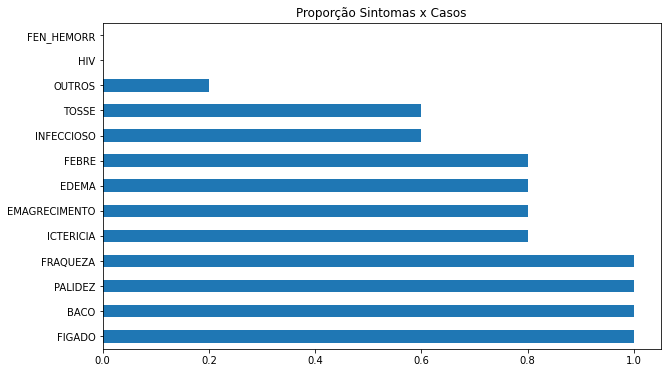

In [18]:
d = ouri.loc[
    (ouri.CO_MN_INF == 150543) & (ouri.ANO == 2019), 
    ['FEBRE', 'FRAQUEZA', 'EDEMA', 'EMAGRECIMENTO', 'TOSSE', 'PALIDEZ', 'BACO', 'INFECCIOSO',
'FEN_HEMORR', 'FIGADO', 'ICTERICIA', 'OUTROS', 'OUTROS_ESP', 'HIV']
]
display(print(f'Outros sintomas: {d.OUTROS_ESP.value_counts()}\n'))
d.select_dtypes('int').replace({2: 0}).mean().sort_values(ascending=False).plot(
    kind='barh',
    figsize=(10,6),
    title="""Proporção Sintomas x Casos"""
);

- Sobre a droga utilizada em 3 casos foi iniciado com Anfotericina B Lipossomal, a droga mais eficiente e com menos efeitos colaterais. Em um dos casos ela só foi administrada porque o tratamento falhou com o Antimonial Pentavalente.
- No caso da gestante não há informação, mas devido à sua condição provavelmente também foi a mesma droga.
- Maioria teve critério de confirmação laboratorial.

In [19]:
d = ouri.loc[
    (ouri.CO_MN_INF == 150543) & (ouri.ANO == 2019), 
    ['TRATAMENTO', 'DT_NOT', 'DROGA', 'DOSE', 'AMPOLAS', 'FALENCIA', 'PESO',
     'CRITERIO', 'DOENCA_TRABALHO', 'IDADE']
] 
d.DROGA = d.DROGA.map({1: 'Antimonial Pentavalente (Glucantime)', 4: 'Anfotericina B Lipossomal'})
d.DOSE = d.DOSE.map({2: 'Maior ou igual a 15 e menor que 20'})
d.FALENCIA = d.FALENCIA.map({2: 'Anfotericina B Lipossomal'})
d.CRITERIO = d.CRITERIO.map({1: 'Laboratorial', 2: 'Clínico-Epidemiológico'})
d.DOENCA_TRABALHO = d.DOENCA_TRABALHO.map({2: 'não'})
d

,TRATAMENTO,DT_NOT,DROGA,DOSE,AMPOLAS,FALENCIA,PESO,CRITERIO,DOENCA_TRABALHO,IDADE
Mulher A,NaN,2019-01-25,Anfotericina B Lipossomal,NaN,NaN,NaN,NaN,Laboratorial,não,74.837950
Mulher B,2019-10-05,2019-10-01,Anfotericina B Lipossomal,NaN,NaN,NaN,NaN,Clínico-Epidemiológico,não,33.032848
Homem A,2019-11-11,2019-11-11,Antimonial Pentavalente (Glucantime),Maior ou igual a 15 e menor que 20,26.0,Anfotericina B Lipossomal,60.0,Laboratorial,não,26.560436
Homem B,NaN,2019-12-16,Anfotericina B Lipossomal,NaN,NaN,NaN,NaN,Clínico-Epidemiológico,NaN,19.173563
Mulher C,NaN,2019-12-30,NaN,NaN,NaN,NaN,NaN,Laboratorial,NaN,21.632203


### 2) Parauapebas viveu um surto de LV após 2016, os municípios vizinhos enfrentaram também uma alta de casos? Como isso se relaciona com este município espacial e temporalmente? Quais municípios vizinhos tiveram alta nas taxas?
- definir os municípios vizinhos de Parauapebas (ou da microrregião)

In [20]:
limitrofes = ['Marabá', 'Curionópolis', 'Canaã dos Carajás', 'Parauapebas', 'Água Azul do Norte', 'São Félix do Xingu']
idx = []
for it in limitrofes:
    idx.append(municipios.loc[municipios.municipio == it, :].index.values[0])
limitrofes = municipios.loc[idx, :]
limitrofes = limitrofes.set_index('ibge_code')
limitrofes


,municipio,estado,mesorregiao,microrregiao
ibge_code,,,,
150420,Marabá,Pará,Sudeste Paraense,Marabá
150277,Curionópolis,Pará,Sudeste Paraense,Parauapebas
150215,Canaã dos Carajás,Pará,Sudeste Paraense,Parauapebas
150553,Parauapebas,Pará,Sudeste Paraense,Parauapebas
150034,Água Azul do Norte,Pará,Sudeste Paraense,Parauapebas
150730,São Félix do Xingu,Pará,Sudeste Paraense,São Félix do Xingu


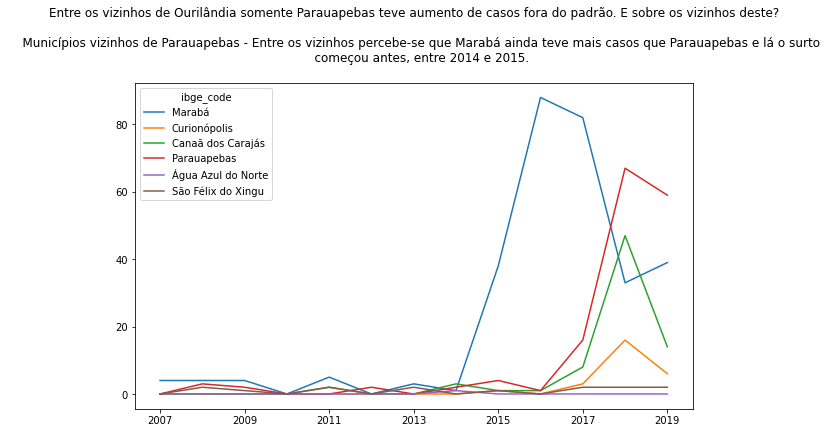

In [21]:
d = total_casos.loc[limitrofes.index,:].copy()
d.index = d.index.map(dict(zip(limitrofes.index, limitrofes.municipio)))
d.T.plot(
    kind='line', 
    figsize=(10,6),
    title='''Entre os vizinhos de Ourilândia somente Parauapebas teve aumento de casos fora do padrão. E sobre os vizinhos deste?\n
    Municípios vizinhos de Parauapebas - Entre os vizinhos percebe-se que Marabá ainda teve mais casos que Parauapebas e lá o surto
    começou antes, entre 2014 e 2015.\n'''
);

In [22]:
microrregiao_parauapebas = municipios.loc[municipios.microrregiao == 'Parauapebas', :]
microrregiao_parauapebas = microrregiao_parauapebas.set_index('ibge_code')
microrregiao_parauapebas

,municipio,estado,mesorregiao,microrregiao
ibge_code,,,,
150034,Água Azul do Norte,Pará,Sudeste Paraense,Parauapebas
150215,Canaã dos Carajás,Pará,Sudeste Paraense,Parauapebas
150277,Curionópolis,Pará,Sudeste Paraense,Parauapebas
150295,Eldorado do Carajás,Pará,Sudeste Paraense,Parauapebas
150553,Parauapebas,Pará,Sudeste Paraense,Parauapebas


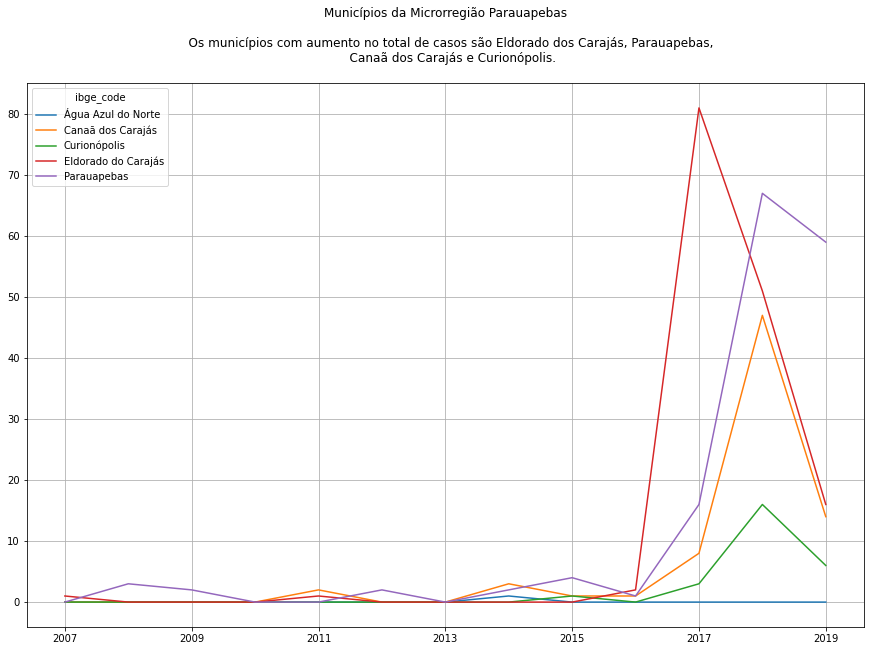

In [27]:
d = total_casos.loc[microrregiao_parauapebas.index,:].copy()
d.index = d.index.map(dict(zip(microrregiao_parauapebas.index, microrregiao_parauapebas.municipio)))
d.T.plot(
    kind='line', 
    figsize=(15,10),
    grid=True,
    title='''Municípios da Microrregião Parauapebas\n
    Os municípios com aumento no total de casos são Eldorado dos Carajás, Parauapebas, 
    Canaã dos Carajás e Curionópolis.\n'''
);

Olhando os municípios da microrregião Parauapebas percebe-se que há municípios que tiveram surtos ainda piores como Eldorado dos Carajás, que 2017 notificou cerca de 80 casos contra menos de 5 no ano anterior, ou seja completamente fora do padrão dos anos anteriores.

Agora vamos visualizar todos municípios da microrregião de Parauapebas ou que sejam seus vizinhos a partir do ano de 2013. 

In [24]:
mun = pd.concat([
    microrregiao_parauapebas,
    limitrofes
], axis=0)
mun = mun[~mun.index.duplicated(keep='first')]
mun

,municipio,estado,mesorregiao,microrregiao
ibge_code,,,,
150034,Água Azul do Norte,Pará,Sudeste Paraense,Parauapebas
150215,Canaã dos Carajás,Pará,Sudeste Paraense,Parauapebas
150277,Curionópolis,Pará,Sudeste Paraense,Parauapebas
150295,Eldorado do Carajás,Pará,Sudeste Paraense,Parauapebas
150553,Parauapebas,Pará,Sudeste Paraense,Parauapebas
150420,Marabá,Pará,Sudeste Paraense,Marabá
150730,São Félix do Xingu,Pará,Sudeste Paraense,São Félix do Xingu


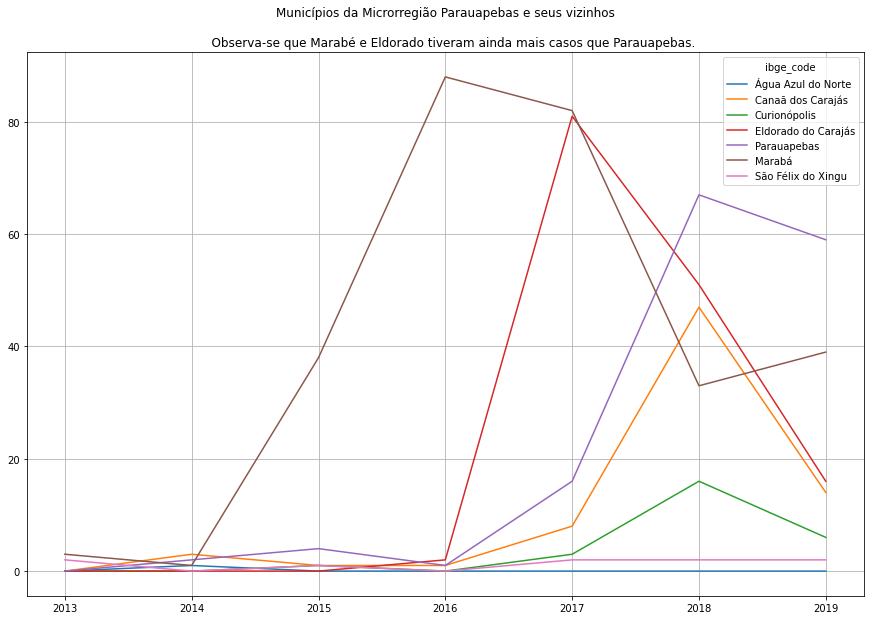

In [29]:
d = total_casos.loc[mun.index, ['2013','2014','2015','2016','2017','2018','2019']].copy()
d.index = d.index.map(dict(zip(mun.index, mun.municipio)))
d.T.plot(
    kind='line', 
    figsize=(15,10),
    grid=True,
    title='''Municípios da Microrregião Parauapebas e seus vizinhos\n
    Observa-se que Marabé e Eldorado tiveram ainda mais casos que Parauapebas.'''
);

- Marabá e Eldorado são municípios muito próximos.
- Parauapebas fica próximo de Marabá e Eldorado, mas não tanto. 
- Canaã fica bem próximo de Parauapebas.